In [3]:
using Revise

using LinearAlgebra
using PyPlot
import TensorCrossInterpolation as TCI
using QuanticsTCI
using ITensors
using Cubature
using BenchmarkTools

rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 9
rcParams["text.usetex"] = true
rcParams["font.family"] = "serif"
rcParams["text.latex.preamble"] = [raw"\usepackage{amsmath}"]
rcParams["font.serif"] = ["Computer Modern Roman"]
rcParams["lines.linewidth"] = 1.0
rcParams["lines.markersize"] = 2

function sumqtt(qtt) where {T}
    if length(qtt) == 0
        return T(0)
    end
    
    v = sum(qtt[end], dims=2)
    for t in qtt[length(qtt)-1:-1:1]
        v *= t
    end
    return v
end

Did not find xfac. QTT functions will not be available.PyError (PyImport_ImportModule

The Python package xfacpy could not be imported by pyimport. Usually this means
that you did not install xfacpy in the Python version being used by PyCall.

PyCall is currently configured to use the Python version at:

/Users/Ritter.Marc/.pyenv/versions/3.8.15/bin/python

and you should use whatever mechanism you usually use (apt-get, pip, conda,
etcetera) to install the Python package containing the xfacpy module.

One alternative is to re-configure PyCall to use a different Python
version on your system: set ENV["PYTHON"] to the path/name of the python
executable you want to use, run Pkg.build("PyCall"), and re-launch Julia.

Another alternative is to configure PyCall to use a Julia-specific Python
distribution via the Conda.jl package (which installs a private Anaconda
Python distribution), which has the advantage that packages can be installed
and kept up-to-date via Julia.  As explained in the P

sumqtt (generic function with 1 method)

In [422]:
a, b = 0, log(20)
A = 1
B = 2^-30
nquantics = 50
ndiscretization = 2^nquantics
#xvals = range(a, b; length=ndiscretization+1)[2:end]

deltax = (b - a) / ndiscretization

xvals(i::BigInt) = a + deltax * i
xvals(i::Int) = xvals(BigInt(i))

step = div(ndiscretization, 2393)
nadd = 4

tolerance = 1e-8

function flin(x)
    return exp(-x^2 / A^2) * cos(x / B) * cos(x /(4 * sqrt(5) * B)) + 2exp(-x)
end

function f(q)
    return flin(xvals(quantics_to_index(q)[1]))
end

struct cachedfunc{ValueType}
    f::Function
    d::Dict{Vector{Int}, ValueType}

    function cachedfunc(::Type{ValueType}, f::Function) where ValueType
        new{ValueType}(f, Dict())
    end
end

function (cf::cachedfunc{ValueType})(x::Vector{Int})::ValueType where {ValueType}
    if haskey(cf.d, x)
        return cf.d[x]
    else
        val = cf.f(x)
        cf.d[deepcopy(x)] = val
        return val
    end
end
    
Base.broadcastable(x::cachedfunc) = Ref(x)
    
cf = cachedfunc(Float64, f)
    
oosindices = [rand([1, 2], nquantics) for _ in 1:2000]
    
function evaluate_qtt(qtt, q::Vector{<:Integer})
    return prod(T[:, i, :] for (T, i) in zip(qtt, q))[1]
end

function maxooserror(f, qtt::Vector{Array{Float64, 3}}, indices::Vector{Vector{Int}})
    if isempty(indices)
        return 0.0
    else
        return maximum(abs(f(i) - evaluate_qtt(qtt, i)) / abs(f(i)) for i in indices)
    end
end
    
function crossinterpolate(
    ::Type{ValueType},
    f::cachedfunc{ValueType},
    localdims::Vector{Int},
    firstpivot::TCI.MultiIndex=ones(Int, length(localdims));
    tolerance::Float64=1e-8,
    maxiter::Int=200,
    sweepstrategy::TCI.SweepStrategies.SweepStrategy=TCI.SweepStrategies.back_and_forth,
    pivottolerance::Float64=1e-12,
    verbosity::Int=0,
    additionalpivots::Vector{TCI.MultiIndex}=TCI.MultiIndex[],
    oosindices::Vector{TCI.MultiIndex}=TCI.MultiIndex[],
    normalizeerror=true
) where {ValueType}
    tci = TCI.TensorCI{ValueType}(f, localdims, firstpivot)
    n = length(tci)
    errors = Float64[]
    relativeerrors = Float64[]
    ooserrors = Float64[]
    integralvalues = Float64[]
    ranks = Int[]

    for pivot in additionalpivots
        addglobalpivot!(tci, f, pivot, tolerance)
    end

    for iter in rank(tci)+1:maxiter
        foward_sweep = (
            sweepstrategy == TCI.SweepStrategies.forward ||
            (sweepstrategy != TCI.SweepStrategies.backward && isodd(iter))
        )

        if foward_sweep
            TCI.addpivot!.(tci, 1:n-1, f, pivottolerance)
        else
            TCI.addpivot!.(tci, (n-1):-1:1, f, pivottolerance)
        end

        errornormalization = normalizeerror ? tci.maxsamplevalue : 1.0
        push!(errors, TCI.lastsweeppivoterror(tci))
        push!(ranks, maximum(rank(tci)))
        
        tt = TCI.tensortrain(tci)
        insindices = collect(setdiff(keys(f.d), oosindices))
        push!(relativeerrors, maxooserror(f, tt, insindices))
        push!(ooserrors, maxooserror(f, tt, oosindices))
        push!(integralvalues, prod(sum(T, dims=2)[:, 1, :] for T in tt)[1] * deltax)
        
        if verbosity > 0 && mod(iter, 10) == 0
            println("rank= $(last(ranks)) , error= $(last(errors))")
        end
        if last(errors) < tolerance
            break
        end
    end

    errornormalization = normalizeerror ? tci.maxsamplevalue : 1.0
    return tci, ranks, errors ./ errornormalization, relativeerrors, ooserrors, integralvalues
end


crossinterpolate (generic function with 2 methods)

In [423]:
typeof(xvals(2^61))

BigFloat

In [424]:
firstpivot = TCI.optfirstpivot(f, fill(2, nquantics)) #, [1, fill(2, nquantics-2)..., 1])

additionalpivots = Vector{Int}[]#index_to_quantics(div(ndiscretization * i, nadd), nquantics) for i in 1:nadd]


time = @elapsed tci, ranks, errors, relativeerrors, ooserrors, integralvalues = crossinterpolate(
    Float64,
    cf,
    fill(2, nquantics),
    firstpivot,
    tolerance=tolerance,
    additionalpivots=additionalpivots,
    oosindices=oosindices
)

println("Elapsed: $time s for $(maximum(ranks)) iterations.")
println(TCI.linkdims(tci))

Elapsed: 2.570075791 s for 15 iterations.
[2, 4, 8, 15, 15, 15, 15, 15, 15, 15, 15, 15, 14, 13, 13, 13, 13, 13, 14, 10, 10, 10, 10, 9, 9, 9, 9, 9, 9, 7, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 2]


In [425]:
@benchmark tci, ranks, errors = TCI.crossinterpolate(
    Float64,
    cf,
    fill(2, nquantics),
    firstpivot,
    tolerance=tolerance,
    additionalpivots=additionalpivots
)

BenchmarkTools.Trial: 87 samples with 1 evaluation.
 Range (min … max):  54.960 ms … 62.840 ms  ┊ GC (min … max): 0.00% … 6.26%
 Time  (median):     59.281 ms              ┊ GC (median):    6.12%
 Time  (mean ± σ):   58.053 ms ±  2.042 ms  ┊ GC (mean ± σ):  4.07% ± 2.97%

   ▁                                         ▃█▁               
  ▇█▅▄▃▄▃▄▃▁▃▁▁▃▁▁▁▁▁▁▁▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▄▄▅███▄▄▁▁▁▃▃▁▃▁▁▁▃ ▁
  55 ms           Histogram: frequency by time        60.8 ms <

 Memory estimate: 28.42 MiB, allocs estimate: 180224.

In [426]:
farray = zeros(fill(2, nquantics)...)
allq = TCI.MultiIndex[]
fimps = ITensor[]

if nquantics <= 12
    allq = [index_to_quantics(i, nquantics) for i in 1:ndiscretization]
    for q in allq
        farray[q...] = f(q)
    end
    findices = [Index(2, "site") for _ in 1:nquantics]
    ftensor = ITensor(farray, findices)
    fimps = [MPS(ftensor, findices; cutoff=tolerance, maxdim=d) for d in 2:min(10, TCI.rank(tci))]
end

LoadError: OutOfMemoryError()

In [427]:
semilogy(1:nquantics-1, [min(2^x, 2^(nquantics-x)) for x in 1:nquantics-1], linewidth=0.5, color="gray")
for m in fimps
    semilogy(1:nquantics-1, linkdims(m), label="MPS, \$\\epsilon=10^{$(log10(tolerance))}\$, rank=$(maximum(linkdims(m)))")
end
semilogy(1:nquantics-1, TCI.linkdims(tci), "k:", label="TCI, \$\\epsilon=10^{$(log10(tolerance))}\$")
xlabel(L"\ell")
ylabel(L"D_\ell")
legend(bbox_to_anchor=(1, 1), loc="upper left")

LoadError: UndefVarError: fimps not defined

In [428]:
integralval = 1.9 #2 * (1 - exp(-3))

semilogy(ranks, errors, label="TCI absolute pivot error")
semilogy(ranks, relativeerrors, label="TCI relative in-sample error")

semilogy(ranks, ooserrors, label="TCI relative out-of-sample error")
semilogy(ranks, abs.(integralvalues .- integralval) / abs(integralval), label="TCI relative integral error")

function mpstoqtt(mps)
    nq = length(mps)
    A = Array{Float64,3}[]
    A1 = zeros(1, 2, linkdim(mps, 1))
    A1[1, :, :] = Array(mps[1], siteind(mps, 1), linkind(mps, 1))
    push!(A, A1)
    for i in 2:nq-1
        push!(A, Array(mps[i], linkind(mps, i-1), siteind(mps, i), linkind(mps, i)))
    end
    Aend = zeros(linkdim(mps, nq - 1), 2, 1)
    Aend[:, :, 1] = Array(mps[nq], linkind(mps, nq-1), siteind(mps, nq))
    push!(A,
    Aend)
    return A
end

@show fmpserrors = [Float64(maxooserror(f, mpstoqtt(m), allq)) for m in fimps]
semilogy(
    [maximum(linkdims(m)) for m in fimps], fmpserrors,
    "ko", label="ITensor MPS (SVD)")

xlabel("rank")
ylabel("error")
legend()

LoadError: UndefVarError: fimps not defined

In [429]:
mps = qtt_to_mps(TCI.tensortrain(tci))
tcieval = Float64[evaluate_mps(mps, siteinds(mps), index_to_quantics(i, nquantics)) for i in 1:step:ndiscretization]
original = Float64[f(index_to_quantics(i, nquantics)) for i in 1:step:ndiscretization]
difference = original .- tcieval;

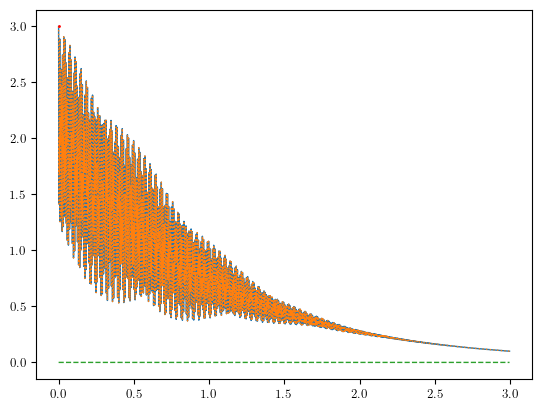

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x2bf7b50d0>

In [430]:
xstep = 1:step:ndiscretization .|> xvals .|> Float64

plot(xstep, original)
plot(xstep, tcieval, ":")
plot(xstep, difference, "--")

plot(
    Float64[xvals(quantics_to_index(firstpivot)[1])],
    Float64[f(firstpivot)], "r.")
plot(
    Float64[xvals(quantics_to_index(a)[1]) for a in additionalpivots],
    Float64[f(a) for a in additionalpivots], "k.")
#for pivot in tci.Jset[1].fromint
#    plot([xvals[quantics_to_index(vcat(pivot, [1]))[1]]], [f(vcat(pivot, [1]))], "k+", label="pivot")
#end

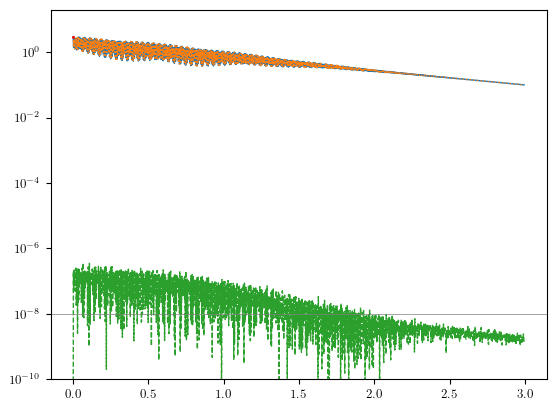

(1.0e-10, 20)

In [431]:
semilogy(xstep, abs.(original))
semilogy(xstep, abs.(tcieval), ":")
semilogy(xstep, abs.(difference), "--")

semilogy(Float64[xvals(quantics_to_index(firstpivot)[1])], Float64[f(firstpivot)], "r.")
semilogy(Float64[xvals(quantics_to_index(a)[1]) for a in additionalpivots], Float64[abs(f(a)) for a in additionalpivots], "k.")
axhline(tolerance, color="gray", linewidth=0.5)
ylim(tolerance / 100, 20)
#xlim(-10, 10)

In [432]:
function sumqtt(qtt)
    vec = sum(qtt[1], dims=2)[:, 1, :]
    for T in qtt[2:end]
        vec *= sum(T, dims=2)[:, 1, :]
    end
    return vec[1]
end

function sum_mps(mps::ITensors.MPS)
    siteindices = siteinds(mps)
    result = ITensor(ones(2), siteindices[1]) * mps[1]
    for (ind, T) in zip(siteindices[2:end], mps[2:end])
        result *= T
        result *= ITensor(ones(2), ind)
    end
    return scalar(result)
end

#findices = [Index(2, "site") for _ in 1:nquantics]
#farray = zeros(fill(2, nquantics)...)
#for q in CartesianIndices(farray)
#    farray[q] = f(Tuple(q))
#end
#fitensor = ITensor(farray, findices...)
#println("Sum of samples: $(sum(fitensor))")

#onestensor = ITensor(ones(fill(2, nquantics)...), findices...)
#direct_sum = scalar(fitensor * onestensor)
#println("Sum over ITensor: $direct_sum")

#mps_itensor = MPS(fitensor, findices, cutoff=tolerance)
#println("direct sum ITensor MPS: $(mps_itensor * onestensor)")
#println("ITensor MPS sum: $(sum_mps(mps_itensor))")

tt = TCI.tensortrain(tci)

deltax = (b - a)/ndiscretization

#println("Integral QTT, backward: $(sumqtt(tt) * deltax)")
qttinttime = @elapsed qttint = prod(sum(T, dims=2)[:, 1, :] for T in tt)[1] * deltax
println("Integral QTT, forward, gives $qttint with $(length(cf.d)) evaluations in $qttinttime s.")
#println("Integral MPS from QTCI: $(sum_mps(mps) * deltax)")

#println("Direct sum integral: $(sum(
#    exp(-x^2 / A^2) * cos(2pi * x / B) * cos(0.1 * 2pi * x / B) for x in xvals.(1:ndiscretization)
#    ) * deltax)")

if abs(B) > 1e-3
    hquadnumevals = 0
    function countf(x::Float64)
        global hquadnumevals += 1
        return flin(x)
    end
    gkinttime = @elapsed cubature_integral, err = hquadrature(countf, a, b, reltol=tolerance, abstol=tolerance)
    print("Cubature.hquadrature gives $cubature_integral +- $err with $(Float64(hquadnumevals)) evals in $gkinttime s")
end

Integral QTT, forward, gives 1.8999999976662931 with 10706 evaluations in 0.015188333 s.


In [433]:
@benchmark qttint = prod(sum(T, dims=2)[:, 1, :] for T in tt)[1] * deltax

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  23.833 μs …  2.249 ms  ┊ GC (min … max):  0.00% … 98.25%
 Time  (median):     25.208 μs              ┊ GC (median):     0.00%
 Time  (mean ± σ):   29.765 μs ± 95.390 μs  ┊ GC (mean ± σ):  14.24% ±  4.38%

        ▂▅▇██▆▄▃▃                                              
  ▁▁▂▂▄▇█████████▅▅▄▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  23.8 μs         Histogram: frequency by time        31.4 μs <

 Memory estimate: 93.02 KiB, allocs estimate: 452.

In [434]:
#@benchmark (cubature_integral, err = hquadrature(countf, a, b, reltol=tolerance, abstol=tolerance))

In [499]:
insetinterval = [0.0, 2^7 * B]

@show ib = [round(Int, (i - a) * ndiscretization / (b - a)) for i in insetinterval]

insetstep = div(ib[2] - ib[1], 1024)
inseteval = Float64[evaluate_mps(mps, siteinds(mps), index_to_quantics(i, nquantics)) for i in ib[1]:insetstep:ib[2]]
insetorig = Float64[f(index_to_quantics(i, nquantics)) for i in ib[1]:insetstep:ib[2]]
insetdiff = inseteval .- insetorig

insetsamplei = filter(
    i -> (
        insetinterval[1] <= xvals(quantics_to_index(i)[1]) <= insetinterval[2] &&
        !(i in oosindices)),
    keys(cf.d))
insetsamplex = Float64[xvals(quantics_to_index(i)[1]) for i in insetsamplei]
insetsampley = Float64[cf.d[i] for i in insetsamplei]

ib = [round(Int, ((i - a) * ndiscretization) / (b - a)) for i = insetinterval] = [0, 44802978]


818-element Vector{Float64}:
 1.8918084830338031
 1.1080321124886845
 2.994995638039182
 2.999999166961506
 2.9999999999958624
 2.6267993707466597
 2.9999997908110636
 1.1841625959446729
 2.7070791928044207
 1.8107392261121784
 2.9999966752693794
 1.1083746811533486
 1.158243546389505
 ⋮
 2.995566356729021
 1.135008157561535
 1.228135486090013
 1.5836792599860097
 1.1124929914241866
 2.073123622132203
 2.999986715932043
 1.8119482594484189
 2.9844443106652916
 2.487491892521175
 1.1076376797494139
 1.6913872171836641

In [537]:
nquantics_list = [40, 30]

tci_list = TCI.TensorCI[]
ranks_list = Vector{Int64}[]
errors_list = Vector{Float64}[]
relativeerrors_list = Vector{Float64}[]
ooserrors_list = Vector{Float64}[]
integralvalues_list = Vector{Float64}[]

for nq in nquantics_list
    ndiscretization_nq = 2^nq
    oosindices_nq = [rand([1, 2], nq) for _ in 1:2000]

    deltax_nq = (b - a) / ndiscretization_nq
    xvals_nq(i::BigInt) = a + deltax_nq * i
    xvals_nq(i::Int) = xvals_nq(BigInt(i))

    function fnq(q)
        return flin(xvals_nq(quantics_to_index(q)[1]))
    end

    cfnq = cachedfunc(Float64, fnq)
    firstpivot_nq = TCI.optfirstpivot(cfnq, fill(2, nq)) #, [1, fill(2, nq-2)..., 1])
    tci_nq, ranks_nq, errors_nq, relativeerrors_nq, ooserrors_nq, integralvalues_nq =
        crossinterpolate(
            Float64,
            cfnq,
            fill(2, nq),
            firstpivot_nq,
            tolerance=tolerance,
            oosindices=oosindices_nq
        )
    push!(tci_list, tci_nq)
    push!(ranks_list, ranks_nq)
    push!(errors_list, errors_nq)
    push!(relativeerrors_list, relativeerrors_nq)
    push!(ooserrors_list, ooserrors_nq)
    push!(integralvalues_list, integralvalues_nq)
end

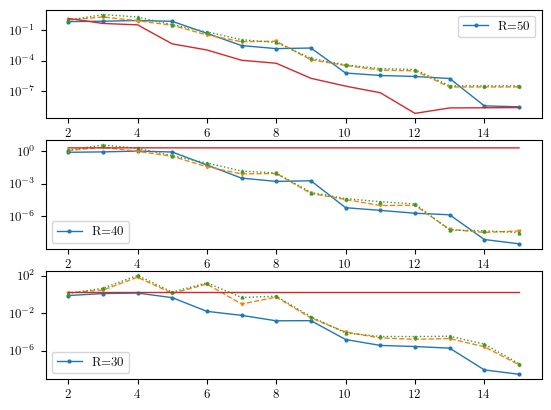

In [538]:
fig, axs = subplots(nrows=(length(nquantics_list)+1))

axs[1].semilogy(ranks, errors, marker="o", label="R=$nquantics")
axs[1].semilogy(ranks, relativeerrors, marker="v", linestyle="--")
axs[1].semilogy(ranks, ooserrors, marker="^", linestyle=":")
axs[1].semilogy(ranks, abs.(integralvalues .- integralval))
axs[1].legend()

for (nq, ax, ranks_nq, errors_nq, relativeerrors_nq, ooserrors_nq, integralvalues_nq) in zip(
        nquantics_list, axs[2:end], ranks_list, errors_list, relativeerrors_list, ooserrors_list, integralvalues_list)
    ax.semilogy(ranks_nq, errors_nq, marker="o", linestyle="-", label="R=$nq")
    ax.semilogy(ranks_nq, relativeerrors_nq, marker="v", linestyle="--")
    ax.semilogy(ranks_nq, ooserrors_nq, marker="^", linestyle=":")
    ax.semilogy(ranks_nq, abs.(integralvalues_nq .- integralval))
    ax.legend()
end

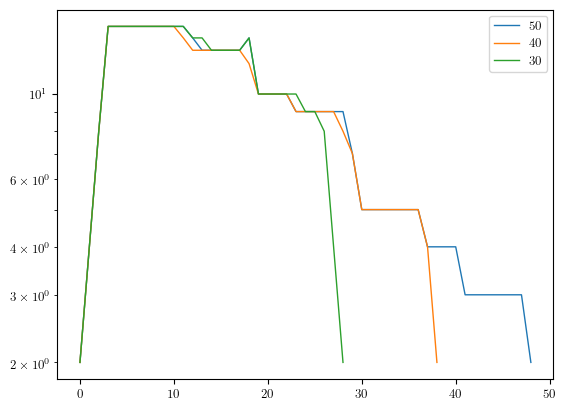

PyObject <matplotlib.legend.Legend object at 0x2c9f4d040>

In [539]:
semilogy(TCI.linkdims(tci), label="$nquantics")
for (nq, tci_nq) in zip(nquantics_list, tci_list)
    semilogy(TCI.linkdims(tci_nq), label="$nq")
end
legend()

In [540]:
#smallstep = div(ndiscretization_small, 1024)

#mps_small = qtt_to_mps(TCI.tensortrain(tci_small))
#tcieval_small = Float64[evaluate_mps(mps_small, siteinds(mps_small), index_to_quantics(i, nquantics_small)) for i in 1:smallstep:ndiscretization_small]
#original_small = Float64[fsmall(index_to_quantics(i, nquantics_small)) for i in 1:smallstep:ndiscretization_small]
#difference_small = original_small .- tcieval_small;

In [541]:
#xstep_small = xvals_small.(1:smallstep:ndiscretization_small)

#plot(xstep_small, original_small)
#plot(xstep_small, tcieval_small, ":")
#plot(xstep_small, difference_small, "--")

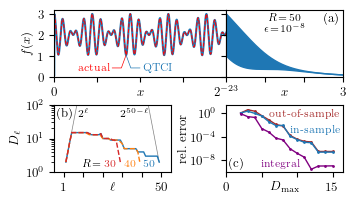

In [551]:
insamplecolor = "tab:blue"
outofsamplecolor = "brown"
integralcolor = "purple"

nqcolors = ["tab:orange", "tab:red"]

origcolor = "red"
origls = "dashed"
origlw = 0.75

# --- Calculate layout ---
ptperinch = 72

figurew, figureh = (246, 140)
padl, padr = -5, 5
padh = 3

xlabelh = 20
ylabelw = 38
errorlabelw = 40

axw = (figurew - padl - padr - ylabelw - errorlabelw) / 2
axh = (figureh - padh) / 2 - xlabelh

zoomaxw = axw + errorlabelw
overvieww = figurew - ylabelw - padl - padr - zoomaxw

errorlegendw = 90

axbottoms = [(i * axh + (i + 1) * xlabelh) for i in 0:1]
units = [figurew, figureh, figurew, figureh]

# --- axes ---

fig = figure(figsize=(figurew/ptperinch, figureh/ptperinch))
    
zoomax = fig.add_axes((ylabelw + padl, axbottoms[2], zoomaxw, axh) ./ units)
overviewax = fig.add_axes((ylabelw + zoomaxw + padl, axbottoms[2], overvieww, axh) ./ units)

bonddimax = fig.add_axes((ylabelw + padl, axbottoms[1], axw, axh) ./ units)
errorax = fig.add_axes((ylabelw + errorlabelw + axw + padl, axbottoms[1], axw, axh) ./ units)

# ---

function customxaxislabel(ax, label, xy=(0.5, 0))
    ax.annotate(
        label,
        xy=xy,
        xycoords="axes fraction",
        xytext=(0, -3.5-rcParams["xtick.major.size"]),
        textcoords="offset points",
        verticalalignment="top",
        horizontalalignment="center")
end

insetx = xvals.(ib[1]:insetstep:ib[2]) .|> Float64
zoomax.plot(insetx, inseteval, linewidth=2 * origlw)
zoomax.plot(insetx, insetorig, color=origcolor, linestyle=origls, linewidth=origlw)
#zoomax.plot(xvals[ib[1]:insetstep:ib[2]], insetdiff)

zoomaxlabelanchor = 17pi * B
zoomax.annotate(
    "actual",
    xy=(zoomaxlabelanchor, flin(zoomaxlabelanchor)),
    xytext=(-12, -6),
    textcoords="offset points",
    horizontalalignment="right",
    verticalalignment="top",
    color=origcolor,
    fontsize="small",
    arrowprops=Dict(
        "arrowstyle"=>"-",
        "color"=>origcolor,
        "linewidth" => 0.5,
        "shrinkA"=> 0,
        "shrinkB"=> 0,
        "connectionstyle"=>"angle,angleA=180,angleB=-110"
    )
)
zoomax.annotate(
    "QTCI",
    xy=(zoomaxlabelanchor, flin(zoomaxlabelanchor)),
    xytext=(12, -6),
    textcoords="offset points",
    horizontalalignment="left",
    verticalalignment="top",
    color=insamplecolor,
    fontsize="small",
    arrowprops=Dict(
        "arrowstyle"=>"-",
        "color"=>insamplecolor,
        "linewidth" => 0.5,
        "shrinkA"=> 0,
        "shrinkB"=> 0,
        "connectionstyle"=>"angle,angleA=0,angleB=-70"
    )
)

if false && !isempty(insetsamplex)
    zoomax.plot(
        insetsamplex, insetsampley,
        "o",
        markerfacecolor="white",
        markeredgecolor=insamplecolor,
        )
    zoomax.annotate(
        "sample",
        xy=(insetsamplex[1], insetsampley[1]),
        xycoords="data",
        xytext=(0, -20),
        textcoords="offset points",
        horizontalalignment="center",
        verticalalignment="top",
        fontsize="small",
        color=insamplecolor,
        arrowprops=Dict(
            "arrowstyle"=>"-",
            "shrinkA"=> 0,
            "shrinkB"=> 8,
            "color"=>insamplecolor,
            "linewidth" => 0.5,
        )
    )
end

customxaxislabel(zoomax, L"$x$")
zoomax.set_ylabel(L"$f(x)$")
zoomax.set_xlim(insetinterval)
zoomax.set_xticks(range(insetinterval..., length=5), [L"$0$", "", "", "", "\$2^{$(Int(log2(insetinterval[2])))}\$"])

xplot = range(0, 3, length=500)
gaussbot(x) = exp(-x^2 / A) + 2exp(-x)
gausstop(x) = -exp(-x^2 / A) + 2exp(-x)
overviewax.fill_between(xplot, gaussbot.(xplot), gausstop.(xplot))
overviewax.plot(xplot, gaussbot.(xplot), "tab:blue")
overviewax.plot(xplot, gausstop.(xplot), "tab:blue")
customxaxislabel(overviewax, L"$x$")

axlim = [0, 3.2]
zoomax.set_ylim(axlim)
overviewax.set_ylim(axlim)

#zoomax.plot(insetx, -gauss.(insetx), "tab:orange")
#zoomax.plot(insetx, gauss.(insetx), "tab:orange")

#overviewax.plot(xvals[1:step:end], tcieval)
overviewax.set_yticks([0, 1, 2, 3], ["", "", "", ""])
zoomax.set_yticks([0, 1, 2, 3])
overviewax.set_xlim(insetinterval[2], b)
overviewax.set_xticks([1, 2, 3], ["", "", L"$3$"])

overviewax.annotate(
    "\$R\\!=\\!$nquantics\$\n\$\\epsilon\\!=\\!10^{-8}\$",
    xy=(0.5, 1),
    xycoords="axes fraction",
    xytext=(0, -3),
    textcoords="offset points",
    verticalalignment="top",
    horizontalalignment="center",
    fontsize="small",
)


bonddimax.semilogy(
    1:nquantics-1, [min(2^x, 2^(nquantics-x)) for x in 1:nquantics-1],
    color="gray", linewidth=0.5, zorder=1.6)

bonddimax.annotate(
    "\$2^\\ell\$",
    xy=(7, 1),
    xycoords=("data", "axes fraction"),
    xytext=(0, -3),
    textcoords="offset points",
    horizontalalignment="left",
    verticalalignment="top",
    fontsize="small",
)
bonddimax.annotate(
    "\$2^{$nquantics - \\ell}\$",
    xy=(nquantics-7, 1),
    xycoords=("data", "axes fraction"),
    xytext=(0, -3),
    textcoords="offset points",
    horizontalalignment="right",
    verticalalignment="top",
    fontsize="small",
)

bonddimax.semilogy(1:nquantics-1, TCI.linkdims(tci), label="\$N=$nquantics\$")

for (nq, color, tci_nq) in zip(nquantics_list, nqcolors, tci_list)
    bonddimax.semilogy(1:nq-1, TCI.linkdims(tci_nq), "--", color=color, label="\$N=$nq\$")
end

bonddimax.set_xlim(-5, nquantics+5)
bonddimax.set_xticks(0:10:nquantics, [L"$1$", fill("", length(0:10:nquantics)-2)..., "\$$(last(0:10:nquantics))\$"])
customxaxislabel(bonddimax, L"$\ell$")
bonddimax.set_ylabel(L"$D_\ell$")
bonddimax.set_ylim(1, 1e2)
#bonddimax.legend(loc="upper center", bbox_to_anchor=(0.5, 1), edgecolor="white", borderpad=0)

#bonddimax.legend(
#    loc="upper right",
#    #bbox_to_anchor=(0.5, 1),
#    frameon=false,
#    borderpad=0,
#    #ncol=4,
#    handlelength=0.7,
#    columnspacing=0.7,
#    handletextpad=0.3,
#    #borderaxespad=0
#)

bonddimax.annotate(
    L"$R\!=$",
    xy=(minimum(nquantics_list), 1),
    xytext=(-15, 4),
    textcoords="offset points",
    horizontalalignment="right",
    fontsize="small"
)

for (nq, color) in zip([nquantics_list..., nquantics], [nqcolors..., insamplecolor])
    bonddimax.annotate(
        "\$$nq\$",
        xy=(nq-1, 1),
        xytext=(-3, 4),
        textcoords="offset points",
        horizontalalignment="right",
        fontsize="small",
        color=color
    )
end

#errorax.semilogy([1, TCI.rank(tci) * 1.2], [tolerance, tolerance], color="gray", linewidth=0.5)
#errorax.axhline(3*tolerance, color="gray", linewidth=0.5)
errorax.semilogy(ranks, ooserrors, ".-", label="out-of-sample", color=outofsamplecolor)
errorax.semilogy(ranks, relativeerrors, ".-", label="in-sample", color=insamplecolor)
errorax.semilogy(ranks, abs.(integralvalues .- integralval) / abs(integralval), ".-", label="integral", color=integralcolor)

errorax.set_xlim(0, 16.5)
errorax.set_ylim(errorax.get_ylim()[1], 25)
#errorax.set_ylabel(L"$\mathrm{error}$")
errorax.set_yticks([1e-8, 1e-4, 1], [L"$10^{-8}$", L"$10^{-4}$", L"$10^0$"])
errorax.annotate(
    "rel.~error",
    xy=(0, 0.5),
    xycoords="axes fraction",
    xytext=(-35, 0),
    textcoords="offset points",
    rotation=90,
    verticalalignment="center",
)

errorax.annotate(
    "in-sample",
    xy=(ranks[8], relativeerrors[8]),
    xytext=(0, 1),
    textcoords="offset points",
    color=insamplecolor,
    horizontalalignment="left",
    verticalalignment="bottom",
    fontsize="small",
)
errorax.annotate(
    "out-of-sample",
    xy=(ranks[5], ooserrors[5]),
    xytext=(0, 1),
    textcoords="offset points",
    color=outofsamplecolor,
    horizontalalignment="left",
    verticalalignment="bottom",
    fontsize="small",
    #xy=(1, 1),
    #xycoords="axes fraction",

)
errorax.annotate(
    "integral",
    xy=(ranks[10], abs.(integralvalues[10] - integralval)),
    #xy=(5, 1e-6),
    #xycoords=("data", "axes fraction"),
    xytext=(-3, -3),
    textcoords="offset points",
    color=integralcolor,
    horizontalalignment="right",
    verticalalignment="top",
    fontsize="small",
)

#errorax.legend(loc="upper left", bbox_to_anchor=(1, 1), frameon=false, borderpad=0)

#errorxticks = [1, 5:5:TCI.rank(tci)...]
#if !(TCI.rank(tci) in errorxticks)
#    push!(errorxticks, TCI.rank(tci))
#end
#errorax.set_xticks(errorxticks)

errorax.set_xticks([0, 5, 10, 15], [L"$0$", "", "", L"$15$"])
#errorax.set_xticks([5, 15], minor=true)
customxaxislabel(errorax, L"$D_{\max}$")

subplotlabeloffset = 2

overviewax.annotate(
    "(a)",
    xy=(1, 1),
    xycoords="axes fraction",
    horizontalalignment="right",
    verticalalignment="top",
    xytext=(-subplotlabeloffset, -subplotlabeloffset),
    textcoords="offset points"
)
bonddimax.annotate(
    "(b)",
    xy=(0, 1),
    xycoords="axes fraction",
    horizontalalignment="left",
    verticalalignment="top",
    xytext=(subplotlabeloffset, -subplotlabeloffset),
    textcoords="offset points",
    #bbox=Dict("boxstyle"=>"square","fc"=>"white","linestyle"=>""),
    zorder=1.8
)
errorax.annotate(
    "(c)",
    xy=(0, 0), 
    xycoords="axes fraction",
    xytext=(subplotlabeloffset, subplotlabeloffset),
    verticalalignment="bottom",
    textcoords="offset points"
)
    
fig.savefig("oned_cosine_gaussian.pdf")

In [543]:
integralvalues .- integralval

14-element Vector{Float64}:
 -1.5529970755948825
 -0.4870429018859863
 -0.3563909151982698
  0.004670892773440238
  0.0011670075313727768
  0.0001119904260618032
  5.660703359633423e-5
  1.8446205827249429e-6
 -3.10461730101963e-7
 -6.867869206672594e-8
 -6.272933283923976e-10
 -2.168896173770918e-9
 -2.246632435642937e-9
 -2.333706783375078e-9

In [544]:
insindices = collect(setdiff(keys(cf.d), oosindices))
println("$(length(insindices)) samples, i.e. $(log(20) / (2pi) / B / length(insindices)) oscillations per sample.")

8706 samples, i.e. 58803.65716532115 oscillations per sample.


In [545]:
B

9.313225746154785e-10

In [546]:
ooserrors


14-element Vector{Float64}:
 1.0252973349688352
 3.7006541297542874
 2.125051062323012
 0.37132864745898986
 0.07148490329945982
 0.012170196053935031
 0.006383299663862334
 0.00017143462286748728
 3.9041560085966187e-5
 1.6691034990385823e-5
 1.361979790189413e-5
 3.316508369343534e-7
 3.3090888861161605e-7
 3.3111758178790267e-7